<a href="https://colab.research.google.com/github/Shivani-Pathak/ANN--Basics/blob/main/Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import PIL.Image

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hook into the target layer
        target_layer.register_forward_hook(self.save_activations)
        target_layer.register_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        self.activations = output

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, input_image, target_class=None):
        # Forward pass
        logits = self.model(input_image)
        if target_class is None:
            target_class = torch.argmax(logits)

        # Backward pass
        self.model.zero_grad()
        logits[0, target_class].backward()

        # Compute Grad-CAM
        weights = torch.mean(self.gradients, dim=(2, 3))  # Global avg pooling
        cam = torch.sum(weights[:, :, None, None] * self.activations, dim=1)
        cam = F.relu(cam)
        print("Shape of cam before interpolation:", cam.shape)

        # Ensure cam has the correct number of spatial dimensions before interpolation
        if len(cam.shape) == 3:  # If cam has only one spatial dimension (C, H) or (C, W)
            cam = cam.unsqueeze(1)  # Add a new dimension to make it (C, 1, H) or (C, 1, W)
        cam = F.interpolate(cam, input_image.shape[2:], mode='bilinear')  # Upsample

        # Normalize
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam

model = torchvision.models.resnet50(pretrained=True)
target_layer = model.layer4[-1].conv3  # Last conv layer
gradcam = GradCAM(model, target_layer)

input_image = PIL.Image.open("/content/drive/MyDrive/Dogs/dog.1.jpg")
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_tensor = input_tensor.unsqueeze(0) # Add a batch dimension


heatmap = gradcam(input_tensor, target_class=281)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hoo

Shape of cam before interpolation: torch.Size([1, 7, 7])


<ipython-input-8-f3af066df732>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('jet')  # Choose a colormap (e.g., 'jet', 'viridis')


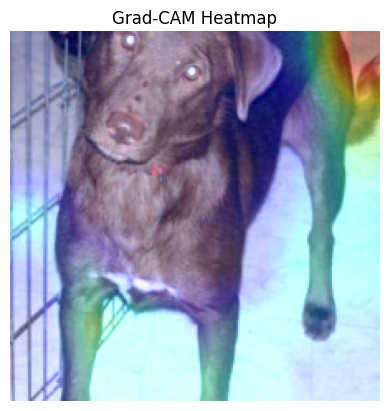

In [ ]:
import numpy as np
def visualize_heatmap(image, heatmap):
    """Visualizes the heatmap overlaid on the original image."""

    # Convert the image and heatmap to numpy arrays
    image = image.squeeze(0).permute(1, 2, 0).cpu().numpy()  # Remove batch dimension and convert to numpy
    # detach the heatmap from the computation graph before converting to numpy
    heatmap = heatmap.squeeze(0).detach().cpu().numpy()  # Remove batch dimension and convert to numpy

    # Normalize the image to the range 0-1
    image = (image - image.min()) / (image.max() - image.min())

    # Resize the heatmap to the image size
    heatmap = heatmap.squeeze()  # Remove the extra dimension if present

    heatmap = np.uint8(255 * heatmap)  # Scale heatmap to 0-255
    heatmap = PIL.Image.fromarray(heatmap).resize(image.shape[:2][::-1])  # Resize using PIL
    heatmap = np.asarray(heatmap) / 255 # Convert back to numpy and normalize

    # Apply colormap to the heatmap
    cmap = plt.cm.get_cmap('jet')  # Choose a colormap (e.g., 'jet', 'viridis')
    heatmap = cmap(heatmap)  # Apply colormap
    heatmap = heatmap[:, :, :3]  # Remove alpha channel

    # Superimpose the heatmap on the image
    superimposed_img = heatmap * 0.4 + image  # Adjust 0.4 for transparency

    # Display the image
    plt.imshow(superimposed_img)
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')
    plt.show()

visualize_heatmap(input_tensor, heatmap)